In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import db

In [2]:
artist = "%Muse%"

sql = 'SELECT rowid, * FROM Artist WHERE name LIKE "%s"' % artist 
dfa = db.dataframe(sql)
dfa

,rowid,name
0,1139,Muse


In [3]:
sql = """
    SELECT A.name, S.title, S.year, O.edition, O.position
    FROM Occurance O
    INNER JOIN Song S ON S.rowid = O.song
    INNER JOIN Artist A ON A.rowid = S.artist
    WHERE A.rowid IN (%s)
""" % ", ".join(str(e) for e in dfa['rowid'].values.tolist())
df = db.dataframe(sql)
df

,name,title,year,edition,position
0,Muse,Uprising,2009,2009,1726
1,Muse,Uprising,2009,2010,1202
2,Muse,Uprising,2009,2011,255
3,Muse,Uprising,2009,2012,175
4,Muse,Uprising,2009,2013,137
...,...,...,...,...,...
123,Muse,Feeling Good,2001,2022,1718
124,Muse,Resistance (Albumversie),2009,2019,804
125,Muse,Resistance (Albumversie),2009,2020,1232
126,Muse,Resistance (Albumversie),2009,2021,1177


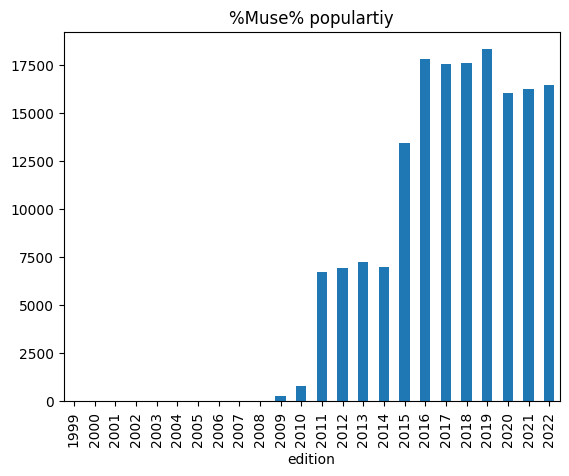

In [4]:
sql = """
    SELECT Y.edition, S.score
    FROM (
        SELECT DISTINCT edition FROM Occurance
    ) Y
    LEFT JOIN ( 
        SELECT O.edition, SUM(2000 - position) AS score
        FROM Occurance O
        INNER JOIN Song S ON S.rowid = O.song
        INNER JOIN Artist A ON A.rowid = S.artist
        WHERE A.rowid IN (%s)
        GROUP BY O.edition
    ) S ON S.edition = Y.edition
""" % ", ".join(str(e) for e in dfa['rowid'].values.tolist())
df = db.dataframe(sql)
df = df.fillna(0)
df = df.set_index('edition')
ax = df.plot.bar(title="{} populartiy".format(artist), legend=False)
plt.show()

In [5]:
dfs = db.dataframe("SELECT rowid, title, year FROM Song WHERE artist IN (%s)" % ", ".join(str(e) for e in dfa['rowid'].values.tolist())).set_index('rowid')
dfs

,title,year
rowid,,
2709,Uprising,2009
2710,Knights Of Cydonia (Albumversie),2006
2711,Plug In Baby,2001
2712,Starlight,2006
2713,Psycho,2015
2714,Mercy,2015
2715,Bliss,2001
2716,Unintended,2009
2717,Supermassive Black Hole,2006


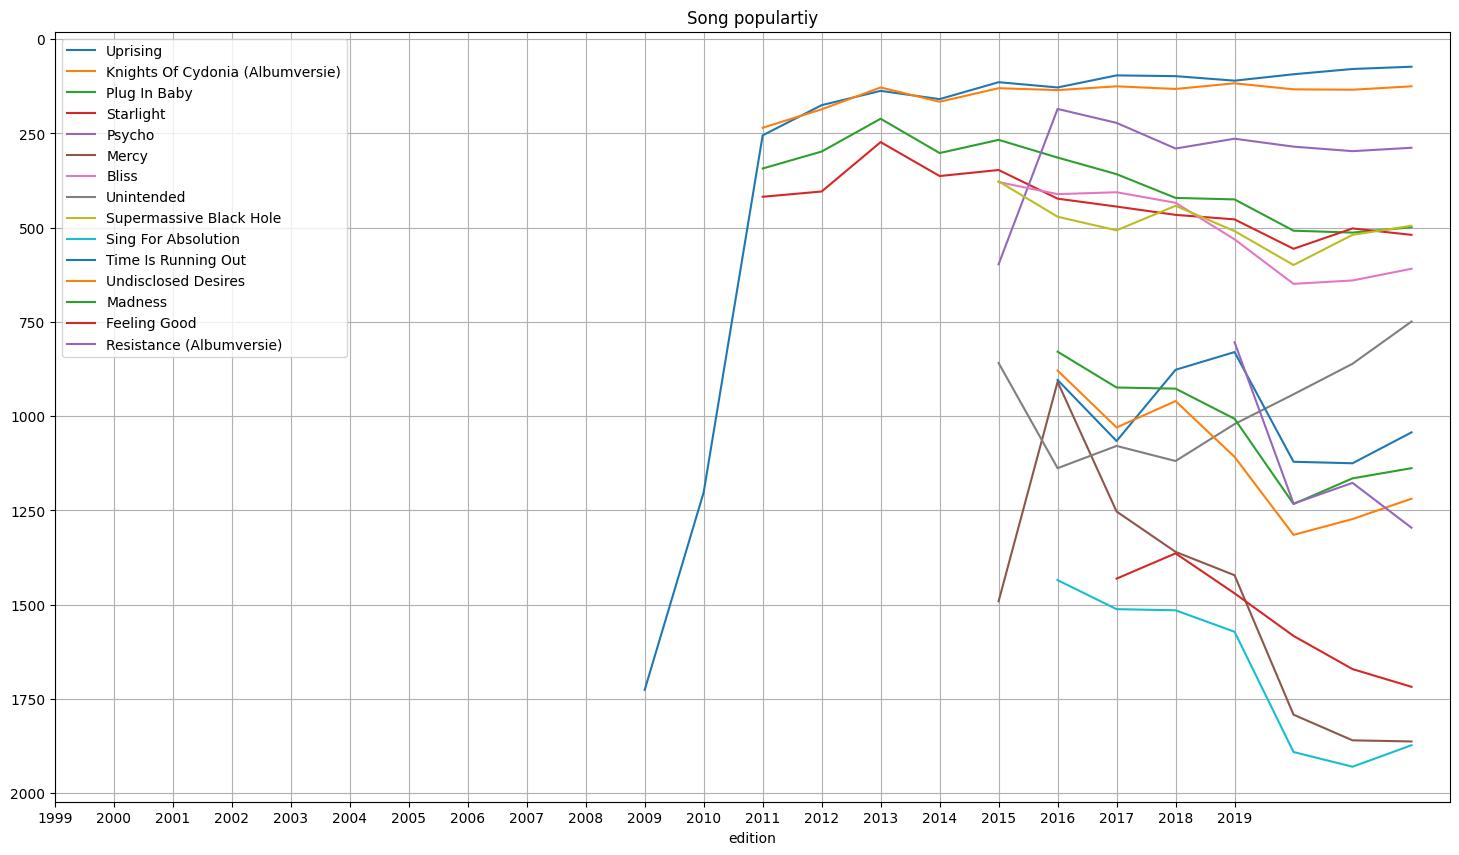

In [7]:
def get_song_score(song_id, song_title):
    sql = """
        SELECT Y.edition, S.position
        FROM (
            SELECT DISTINCT edition FROM Occurance
        ) Y
        LEFT JOIN ( 
            SELECT O.edition, position 
            FROM Occurance O
            INNER JOIN Song S ON S.rowid = O.song
            WHERE S.rowid = %d
            GROUP BY O.edition
        ) S ON S.edition = Y.edition
    """ % song_id
    return db.dataframe(sql).set_index('edition').rename(columns={'position' : song_title})

is_first = True


for index, row in dfs.iterrows():
    title = row['title']
    dft = get_song_score(index, title)
    if (is_first):
        dfr = dft
        is_first = False
    else:
        dfr[title] = dft[title]
    
ax = dfr.plot(figsize=(18, 10), title="Song populartiy", xticks=range(1999, 2020), grid=True).invert_yaxis()

#dfr